<a href="https://colab.research.google.com/github/monicaneli/Reconhecimento-Facial/blob/main/Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção e reconhecimento facial
um sistema de detecção e reconhecimento de faces.

Para isso, foi utilizada uma rede de detecção treinada para detectar faces e utilizá-la para classificar uma face específica.

Para a tarefa de detecção foi utilizada a lexeyAB's darknet juntamente com YOLOv4.


In [1]:
# Imports e parâmetros
import os
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
# @title
# Funções

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio


  # function to convert the JavaScript object into an OpenCV image

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
    # save image
  cv2.imwrite(filename, img)

  return filename


  # JavaScript to properly create our live video stream using our webcam as input

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
  ''')
  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


## Detecção de rostos com YOLOv4



## Reconhecimento de faces com FaceNet

classificação

In [3]:
!pip install keras-facenet

In [4]:
from keras_facenet import FaceNet
import numpy as np

# Carregar FaceNet
embedder = FaceNet()

# Função para extrair embeddings de uma face
def get_embedding(face_img):
    # Redimensionar para 160x160, que é o padrão do FaceNet
    face = cv2.resize(face_img, (160, 160))
    face = face.astype("float32")
    face = np.expand_dims(face, axis=0)
    return embedder.embeddings(face)[0]


In [5]:
#Comparar face detectada com banco
from numpy.linalg import norm

def recognize_face(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return "Erro: imagem não carregada"
    emb = get_embedding(img)
    pred = knn.predict([emb])[0]
    proba = knn.predict_proba([emb])[0]
    return le.inverse_transform([pred])[0], np.max(proba)

def recognize_face2(face_img, threshold=0.8):
    emb = get_embedding(face_img)
    best_match = None
    best_score = float("inf")

    for person, embeddings in known_faces.items():
        for ref_emb in embeddings:
            score = norm(emb - ref_emb)
            if score < best_score:
                best_score = score
                best_match = person

    if best_score < threshold:
        return best_match, best_score
    else:
        return "Desconhecido", best_score


In [6]:
# Banco de faces para reconhecimento

# Dataset Big Bang Theory
!wget -O TBBT.zip "https://github.com/monicaneli/Reconhecimento-Facial/raw/main/TBBT.zip"
!unzip -q TBBT.zip

--2025-09-15 20:03:30--  https://github.com/monicaneli/Reconhecimento-Facial/raw/main/TBBT.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/main/TBBT.zip [following]
--2025-09-15 20:03:30--  https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/main/TBBT.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550271 (537K) [application/zip]
Saving to: ‘TBBT.zip’

TBBT.zip            100%[===================>] 537.37K  --.-KB/s    in 0.004s  

2025-09-15 20:03:31 (133 MB/s) - ‘TBBT.zip’ saved [550271/550271]



In [7]:
# Pasta de rostos extraídos do dataset
dataset_path = "/content/TBBT"
embedder = FaceNet()
X, y = [], []

def augment_image(img):
    """Aplica aumentos simples em uma imagem"""
    aug_imgs = []

    # 1. Flip horizontal
    aug_imgs.append(cv2.flip(img, 1))

    # 2. Rotação pequena
    angle = random.choice([-10, -5, 5, 10])
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    aug_imgs.append(cv2.warpAffine(img, M, (w, h)))

    # 3. Alterar brilho
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[...,1] = hsv[...,1]*random.uniform(0.8,1.2)
    hsv[...,2] = hsv[...,2]*random.uniform(0.7,1.3)
    hsv[hsv > 255] = 255
    aug_imgs.append(cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2BGR))

    return aug_imgs

# Preparando o dataset
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (160, 160))

        # Embedding da imagem original
        X.append(embedder.embeddings([img])[0])
        y.append(person)

        # Augmentation → Embeddings das variações
        for aug in augment_image(img):
            aug = cv2.resize(aug, (160, 160))
            X.append(embedder.embeddings([aug])[0])
            y.append(person)

X = np.array(X)
y = np.array(y)

print("Total de embeddings após augmentation:", X.shape, "Labels:", len(y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [8]:
# Transformar rótulos em inteiros
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Treinar um KNN simples
knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn.fit(X, y_enc)

print("Classes:", le.classes_)


Classes: ['Amy' 'Bernadete' 'Howard' 'Leonard' 'Penny' 'Raj' 'Sheldon']


In [9]:
!wget -O the-big-bang-theory-3.jpg 'https://observatoriodocinema.com.br/wp-content/plugins/seox-image-magick/imagick_convert.php?width=1869&height=1402&format=.jpg&quality=91&imagick=/wp-content/uploads/2022/03/the-big-bang-theory-3.jpg'
!wget -O Amy_TBBT.jpg  'https://aventurasnahistoria.com.br/wp-content/uploads/curiosidades/amy_fowler_mayim_bialik.jpg'

--2025-09-15 20:04:26--  https://observatoriodocinema.com.br/wp-content/plugins/seox-image-magick/imagick_convert.php?width=1869&height=1402&format=.jpg&quality=91&imagick=/wp-content/uploads/2022/03/the-big-bang-theory-3.jpg
Resolving observatoriodocinema.com.br (observatoriodocinema.com.br)... 104.21.70.51, 172.67.220.1, 2606:4700:3037::6815:4633, ...
Connecting to observatoriodocinema.com.br (observatoriodocinema.com.br)|104.21.70.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpg]
Saving to: ‘the-big-bang-theory-3.jpg’

the-big-bang-theory     [      <=>           ] 559.53K   357KB/s    in 1.6s    

2025-09-15 20:04:29 (357 KB/s) - ‘the-big-bang-theory-3.jpg’ saved [572955]

--2025-09-15 20:04:29--  https://aventurasnahistoria.com.br/wp-content/uploads/curiosidades/amy_fowler_mayim_bialik.jpg
Resolving aventurasnahistoria.com.br (aventurasnahistoria.com.br)... 172.67.213.242, 104.21.16.157, 2606:4700:3034::ac43:d5f2, ...
Connecting t

In [10]:
# Exemplo: testar com uma imagem da Amy
test_img = '/content/Amy_TBBT.jpg'
label, score = recognize_face(test_img)
print("Reconhecido como:", label, " (confiança:", score, ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Reconhecido como: Howard  (confiança: 0.6666666666666666 )


## Multipls

In [11]:
!pip install mtcnn

from mtcnn import MTCNN
import cv2

detector = MTCNN()


In [12]:
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN

detector = MTCNN()


In [13]:
def recognize_faces_in_frame(frame_path, knn, embedder, le):
    # Carregar frame
    img = cv2.imread(frame_path)
    if img is None:
        return "Erro ao carregar imagem"
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detectar faces
    results = detector.detect_faces(rgb)
    print("Faces detectadas:", len(results))

    for res in results:
        x, y, w, h = res['box']
        face = rgb[y:y+h, x:x+w]
        face = cv2.resize(face, (160, 160))

        # Extrair embedding
        emb = embedder.embeddings([face])[0]

        # Predição
        pred = knn.predict([emb])[0]
        proba = knn.predict_proba([emb])[0]
        label = le.inverse_transform([pred])[0]
        score = np.max(proba)

        # Desenhar bounding box e nome
        cv2.rectangle(rgb, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(rgb, f"{label} ({score:.2f})", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    # Mostrar imagem final
    plt.figure(figsize=(10,8))
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

Faces detectadas: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


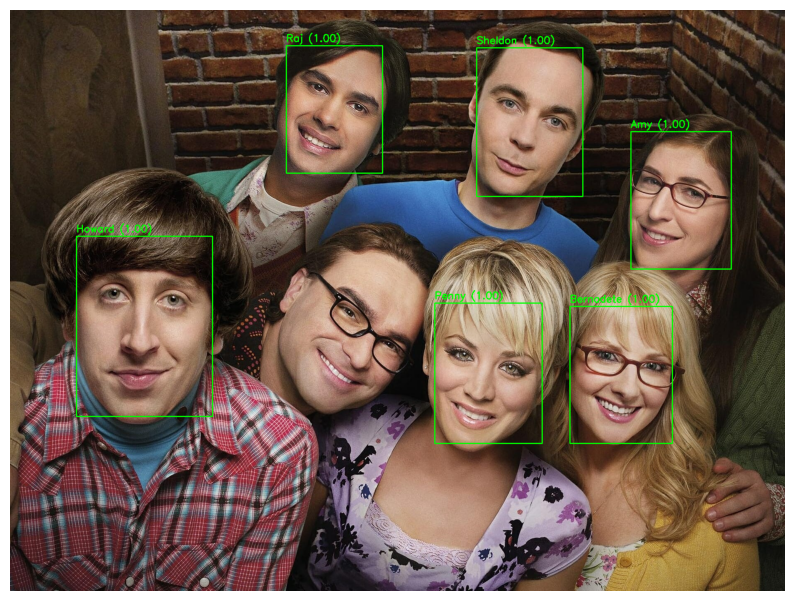

In [14]:
frame_path = "/content/the-big-bang-theory-3.jpg"  # vários personagens
recognize_faces_in_frame(frame_path, knn, embedder, le)

## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

In [ ]:
# Obter imagem de exemlo
!wget -O /content/pessoas.jpg https://github.com/serengil/deepface/blob/master/tests/dataset/selfie-many-people.jpg

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("pessoas.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

##YOLOv4 on Wecam Images
Running YOLOv4 on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's Code Snippets that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for Camera Capture which runs JavaScript code to utilize your computer's webcam. The code snippet will take a webcam photo, which we will then pass into our YOLOv4 model for object detection.

Below is a function to take the webcam picture using JavaScript and then run YOLOv4 on it.

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## YOLOv4 on Webcam Videos
Running YOLOv4 on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our YOLOv4 model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

YOLOv4 is so fast that it can run the detections in real-time!

## Running on Webcam Video
Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

## Referências

[1] YOLOv4 Object Detection on Webcam In Google Colab por [Jack Wotherspoon](https://github.com/jackwotherspoon)

[2] Bootcamp BairesDev - Machine Learning Training pela DIO